In [1]:
### LIBRARIES / HEADER STUFF {
import json
from graphviz import Digraph
### }

In [30]:
### Hyperparams {
remove_grad_classes = True
color_requirements = False
required = {'PHYS039','MATH009A','MATH009B','MATH009C','CHEM001A',
                'CHEM001B','CHEM001C','CS010','MATH010A','MATH010B','MATH046',
                'PHYS041A','PHYS041B','PHYS041C','PHYS130A','PHYS130B','PHYS132',
                'PHYS135A','PHYS135B','PHYS156A','PHYS156B','PHYS139L','PHYS142W'}
draw_boxes = False
annotate_labels = False
### }

In [39]:
### IMPORT FROM DATASET {

# Opens and autocloses the file, binds file to f, and loads the data
with open('/home/order/Dropbox/Python_Code/Cloned/ucr-course-graph/data/201740_all_prereqs.json','r') as f:
    data = json.load(f)

# Define course object
class course:
    def __init__(self, courseName, preReq, courseID, subject):
        self.courseName = courseName
        self.preReq = preReq
        self.courseID = courseID
        self.subject = subject

# Mildly brittle parser
def parseAndOr(testString):
    if testString == dict():
        return dict()
    if len(testString.split('\n')) < 3:
        return dict()
    if 'Score for' in testString: # EXTREMELY HACKY SOLUTION
        return dict()
    mod = testString.split('and\n')
    mod = [x.split('or\n') for x in mod]
    mod = [[y.split('\n') for y in x] for x in mod]
    # mod = [[[z for z in y] for y in x] for x in mod]
    def classconvert(classname):
        intermed = classname.split(' ')
        intermed = [' '.join(intermed[:-1]), intermed[-1]]
        lookup = {
            'Computer Science':'CS',
            'Physics':'PHYS',
            'Mathematics':'MATH',
            'Electrical Engineering':'EE',
            'Mechanical Engineering':'ME',
            'Bioengineering':'BIEN',
            'Chemistry':'CHEM',
            'English':'ENGL'
        }
        if intermed[0] in lookup:
            return lookup[intermed[0]] + intermed[1]
        else:
            return classname
    
    try:
        # This is the most horrific list comprehension I've every written, but it works
        mod = [[[
             classconvert(y[1][y[1].index('Test:')+6:].strip()), # Class name
             y[2].split(' ')[-1], # Grade
             'NC' if y[3].strip()[:7] == 'May not' else 'C' # Concurrent allowed?
                ] if y[0] == '(' else [
             classconvert(y[0][y[0].index('Test:')+6:].strip()), # Class name
             y[1].split(' ')[-1], # Grade
             'NC' if y[2].strip()[:7] == 'May not' else 'C' # Concurrent allowed?
                ] for y in x] for x in mod]
    except:
        print(testString)
        print(mod)
        raise
    return mod

courseList = []
for currentCourse in data:
    try: # Dealing with situations where prereq didn't get written
        mycourse = course(currentCourse['subjectCourse'], parseAndOr(currentCourse['prereqs']), currentCourse['id'], currentCourse['subject'])
    except KeyError:
        mycourse = course(currentCourse['subjectCourse'], dict(), currentCourse['id'], currentCourse['subject'])
    courseList.append(mycourse) # Writes course objects to a list

for i in courseList:
    if i != dict():
        print(i.preReq)

### }

{}
{}
{}
{}
[[['Anthropology 001', 'D-', 'NC'], ['Anthropology 001H', 'D-', 'NC'], ['Anthropology 001W', 'D-', 'NC']]]
[[['Anthropology 003', 'D-', 'NC'], ['Anthropology 005', 'D-', 'NC']]]
[[['Anthropology 003', 'D-', 'NC'], ['Anthropology 005', 'D-', 'NC']]]
[[['Anthropology 001', 'D-', 'NC'], ['Anthropology 001H', 'D-', 'NC'], ['Anthropology 001W', 'D-', 'NC']], [['Linguistics 020', 'D-', 'NC']]]
[[['Anthropology 001', 'D-', 'NC'], ['Anthropology 001H', 'D-', 'NC'], ['Anthropology 001W', 'D-', 'NC']]]
[[['Linguistics 020', 'D-', 'NC']]]
[[['Anthropology 001', 'D-', 'NC'], ['Anthropology 001H', 'D-', 'NC'], ['Anthropology 001W', 'D-', 'NC']]]
[[['Anthropology 002', 'D-', 'NC']]]
[[['Anthropology 002', 'D-', 'NC']]]
{}
[[['Anthropology 001', 'D-', 'NC'], ['Anthropology 001H', 'D-', 'NC'], ['Anthropology 001W', 'D-', 'NC']]]
{}
[[['Arabic Language 003', 'C-', 'NC']]]
{}
{}
{}
{}
{}
{}
{}
{}
{}
[[['Art 001', 'D-', 'NC']], [['Art 002', 'D-', 'NC']]]
[[['Art 001', 'D-', 'NC']], [['Art 002

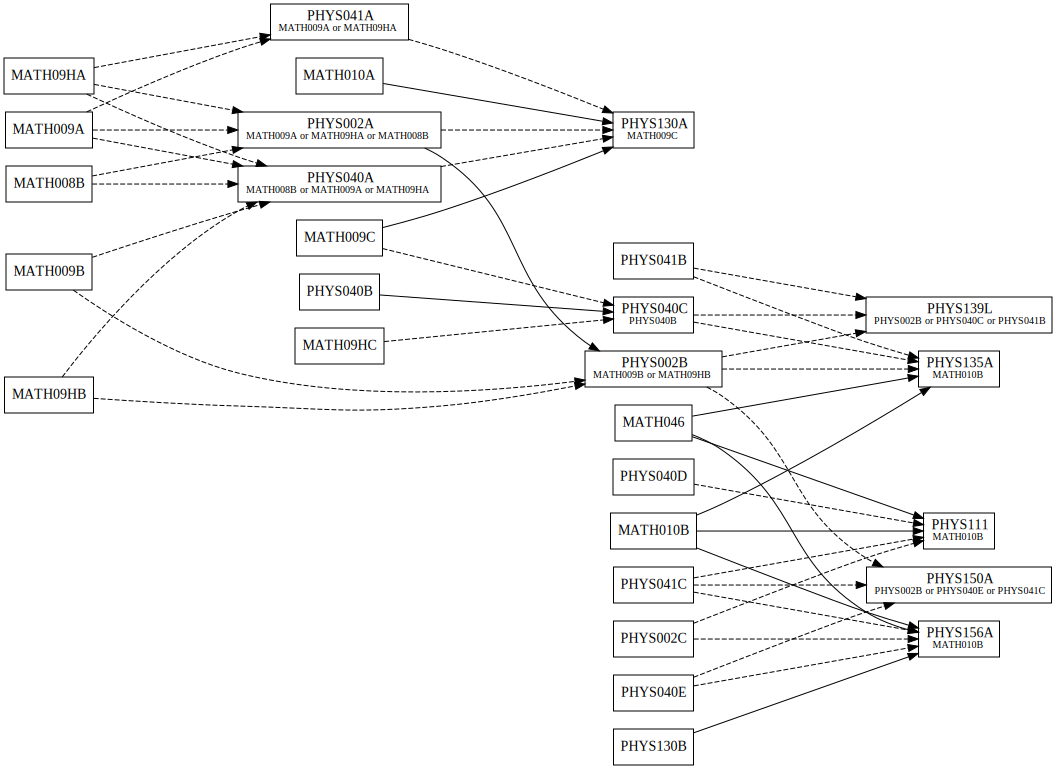

In [80]:
### RENDER GRAPH {

def undergradOnly(courseList):
    numbers = set('0123456789')
    return [x for x in courseList if [y for y in x.courseName if y in numbers][0] in {'0','1'}]

def selectMajor(courseList,major):
    # Use 4-code for major (eg 'PHYS')
    return [x for x in courseList if x.subject == major]

len(courseList)
len(selectMajor(courseList,'PHYS'))

major = 'PHYS'
if remove_grad_classes:
    physList = undergradOnly(selectMajor(courseList,major))
else:
    physList = selectMajor(courseList,major)

dot = Digraph(comment='classflow test',graph_attr={'rankdir': 'LR',
                                                  'ranksep': '2'})


# Define how to draw between courses (with all the relevant conditions)
def requisiteLine(fromCourse,toCourse,graph,labelInfo=False,**args):
    """fromCourse example: "['ANTH001', 'D-', 'NC']"
       toCourse example: "course" object with courseName, etc.
       Creates nodes on both ends, then draws the requisite line between the two of them.
       Also references the global required list"""
    # Create nodes
    shape = 'box'
    if color_requirements:
        for toNode in [fromCourse[0],toCourse.courseName]:
            if toNode in required:
                if labelInfo:
                    graph.node(toNode,style='filled',color='gold',shape=shape, label='<' + toNode + '<BR /><FONT POINT-SIZE="10">' + labelInfo +'</FONT>>')
                else:
                    graph.node(toNode,style='filled',color='gold',shape=shape)
            else:
                if labelInfo:
                    graph.node(toNode,style='filled',color='lightblue2',shape=shape, label='<' + toNode + '<BR /><FONT POINT-SIZE="10">' + labelInfo +'</FONT>>')
                else:
                    graph.node(toNode,style='filled',color='lightblue2',shape=shape)
    else:
        for toNode in [fromCourse[0],toCourse.courseName]:
            if labelInfo:
                graph.node(toNode,shape=shape, label='<' + toNode + '<BR /><FONT POINT-SIZE="10">' + labelInfo +'</FONT>>')
            else:
                graph.node(toNode,shape=shape)
    
    # Draw line
    graph.edge(fromCourse[0],toCourse.courseName,**args)

# Create lines between courses
runID = 0
for i in physList:
    if i.preReq != dict():
        # i.preReq is "and_group"
        for orGroup in i.preReq:
            if len(orGroup) > 1:
                # draw box
                with dot.subgraph(name='cluster_' + str(runID)) as c:
                    for classInfo in orGroup:
                        if draw_boxes:
                            c.attr(style='filled')
                            c.attr(color='lightgrey')
                            c.node_attr.update(style='filled', color='white')
                            requisiteLine(classInfo,i,c,style='dashed')
                        else:
                            requisiteLine(classInfo,i,dot,style='dashed')
                runID += 1
                
                dot.node(i.courseName,label='<' + i.courseName + '<BR /><FONT POINT-SIZE="10">' + ' or '.join([x[0] for x in i.preReq[0]]) +'</FONT>>')
            else:
                requisiteLine(orGroup[0],i,dot)

# if color_requirements:
#     # Color classes that are required
#     required = {'PHYS039','MATH009A','MATH009B','MATH009C','CHEM001A',
#                 'CHEM001B','CHEM001C','CS010','MATH010A','MATH010B','MATH046',
#                 'PHYS041A','PHYS041B','PHYS041C','PHYS130A','PHYS130B','PHYS132',
#                 'PHYS135A','PHYS135B','PHYS156A','PHYS156B','PHYS139L','PHYS142W'}
#     current_nodes = set([x.split(' ')[0][1:] for x in dot.__dict__['body']])
#     current_nodes.remove('subgraph')
#     current_nodes.remove('}')
#     for node in current_nodes:
#         if node in required:
#             dot.node(node, style='filled',color='gold')
#         else:
#             dot.node(node, style='filled',color='lightblue')

### }
# dot.node('MATH009C',shape='box',label='<MATH009C<BR /><FONT POINT-SIZE="10">MATH009<BR/>MATH010B</FONT>>')
dot

In [24]:
dot.render(filename='./test',view=True,format='png')

'./test.png'

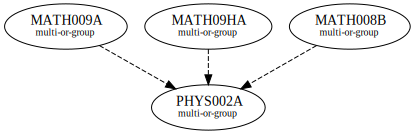

In [57]:
dot